In [11]:
import sys
sys.path.append('../')
sys.path.append('./')

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

from tqdm import tqdm

from collections import defaultdict

from utils.config import DATASET_PATH

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.5)

### Изучим зависимости таргета от различных признаков.

In [13]:
data = pd.read_csv('../'+DATASET_PATH, index_col=[0, 1])
data = data.reset_index(drop=True)
data = data.drop(['position', 'age'], axis=1)
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
0,11156.76,123.532772,11380.0,10836.0,1.244884e+08,177.0,1158.80,73.172275,1348.0,920.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
1,11156.88,128.858961,11380.0,10836.0,1.244924e+08,193.0,1137.96,69.416023,1300.0,920.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
2,11154.36,134.410311,11532.0,10836.0,1.244376e+08,190.0,1088.32,171.829072,1380.0,164.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3,10998.28,415.506022,11532.0,9384.0,1.211331e+08,323.0,853.36,499.190851,1380.0,-1032.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
4,10883.04,409.575930,11532.0,9384.0,1.186066e+08,543.0,537.68,622.192456,1380.0,-1032.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1


In [14]:
y = data['is_valid']
X = data.drop('is_valid', axis=1)

In [15]:
C = 2
max_iter = 10000

### Baseline

In [16]:
def evaluate_metrics(X, y):    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=1234
    )
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    logreg = LogisticRegression(
        multi_class='multinomial', max_iter=max_iter, random_state=42, C=C
    ).fit(X_train, y_train)
    svc = SVC(kernel='linear', C=C).fit(X_train, y_train)
    
    y_pred_logreg = logreg.predict(scaler.transform(X_test))
    accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

    y_pred_svc = svc.predict(scaler.transform(X_test))
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    
    print(f"LogReg accuracy: {accuracy_logreg:.3f}")
    print(f"SVC accuracy: {accuracy_svc:.3f}")
    
    return logreg, svc

In [17]:
logreg, svc = evaluate_metrics(X, y)

LogReg accuracy: 0.824
SVC accuracy: 0.836


### Отбор признаков

Выделим самые значимые по мнению алгоритма метрики, по которым хорошо разделяются классы.

In [12]:
#  Сортированные метрики по важности
odds = np.exp(logreg.coef_[0])
sorted_metrics = pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
sorted_metrics

,coef
x_energy,76.459884
z_energy,24.061758
x_iqr_pos1,4.627020
y_std_pos1,4.596197
z_max_pos1,3.699542
height,3.054001
y_min_pos1,2.649295
x_std,2.010990
z_energy_pos1,1.846540
z_mean_pos1,1.795144


In [13]:
sorted_metrics = list(sorted_metrics.index)

Посмотрим на распределение признаков и их разбиение по классам.

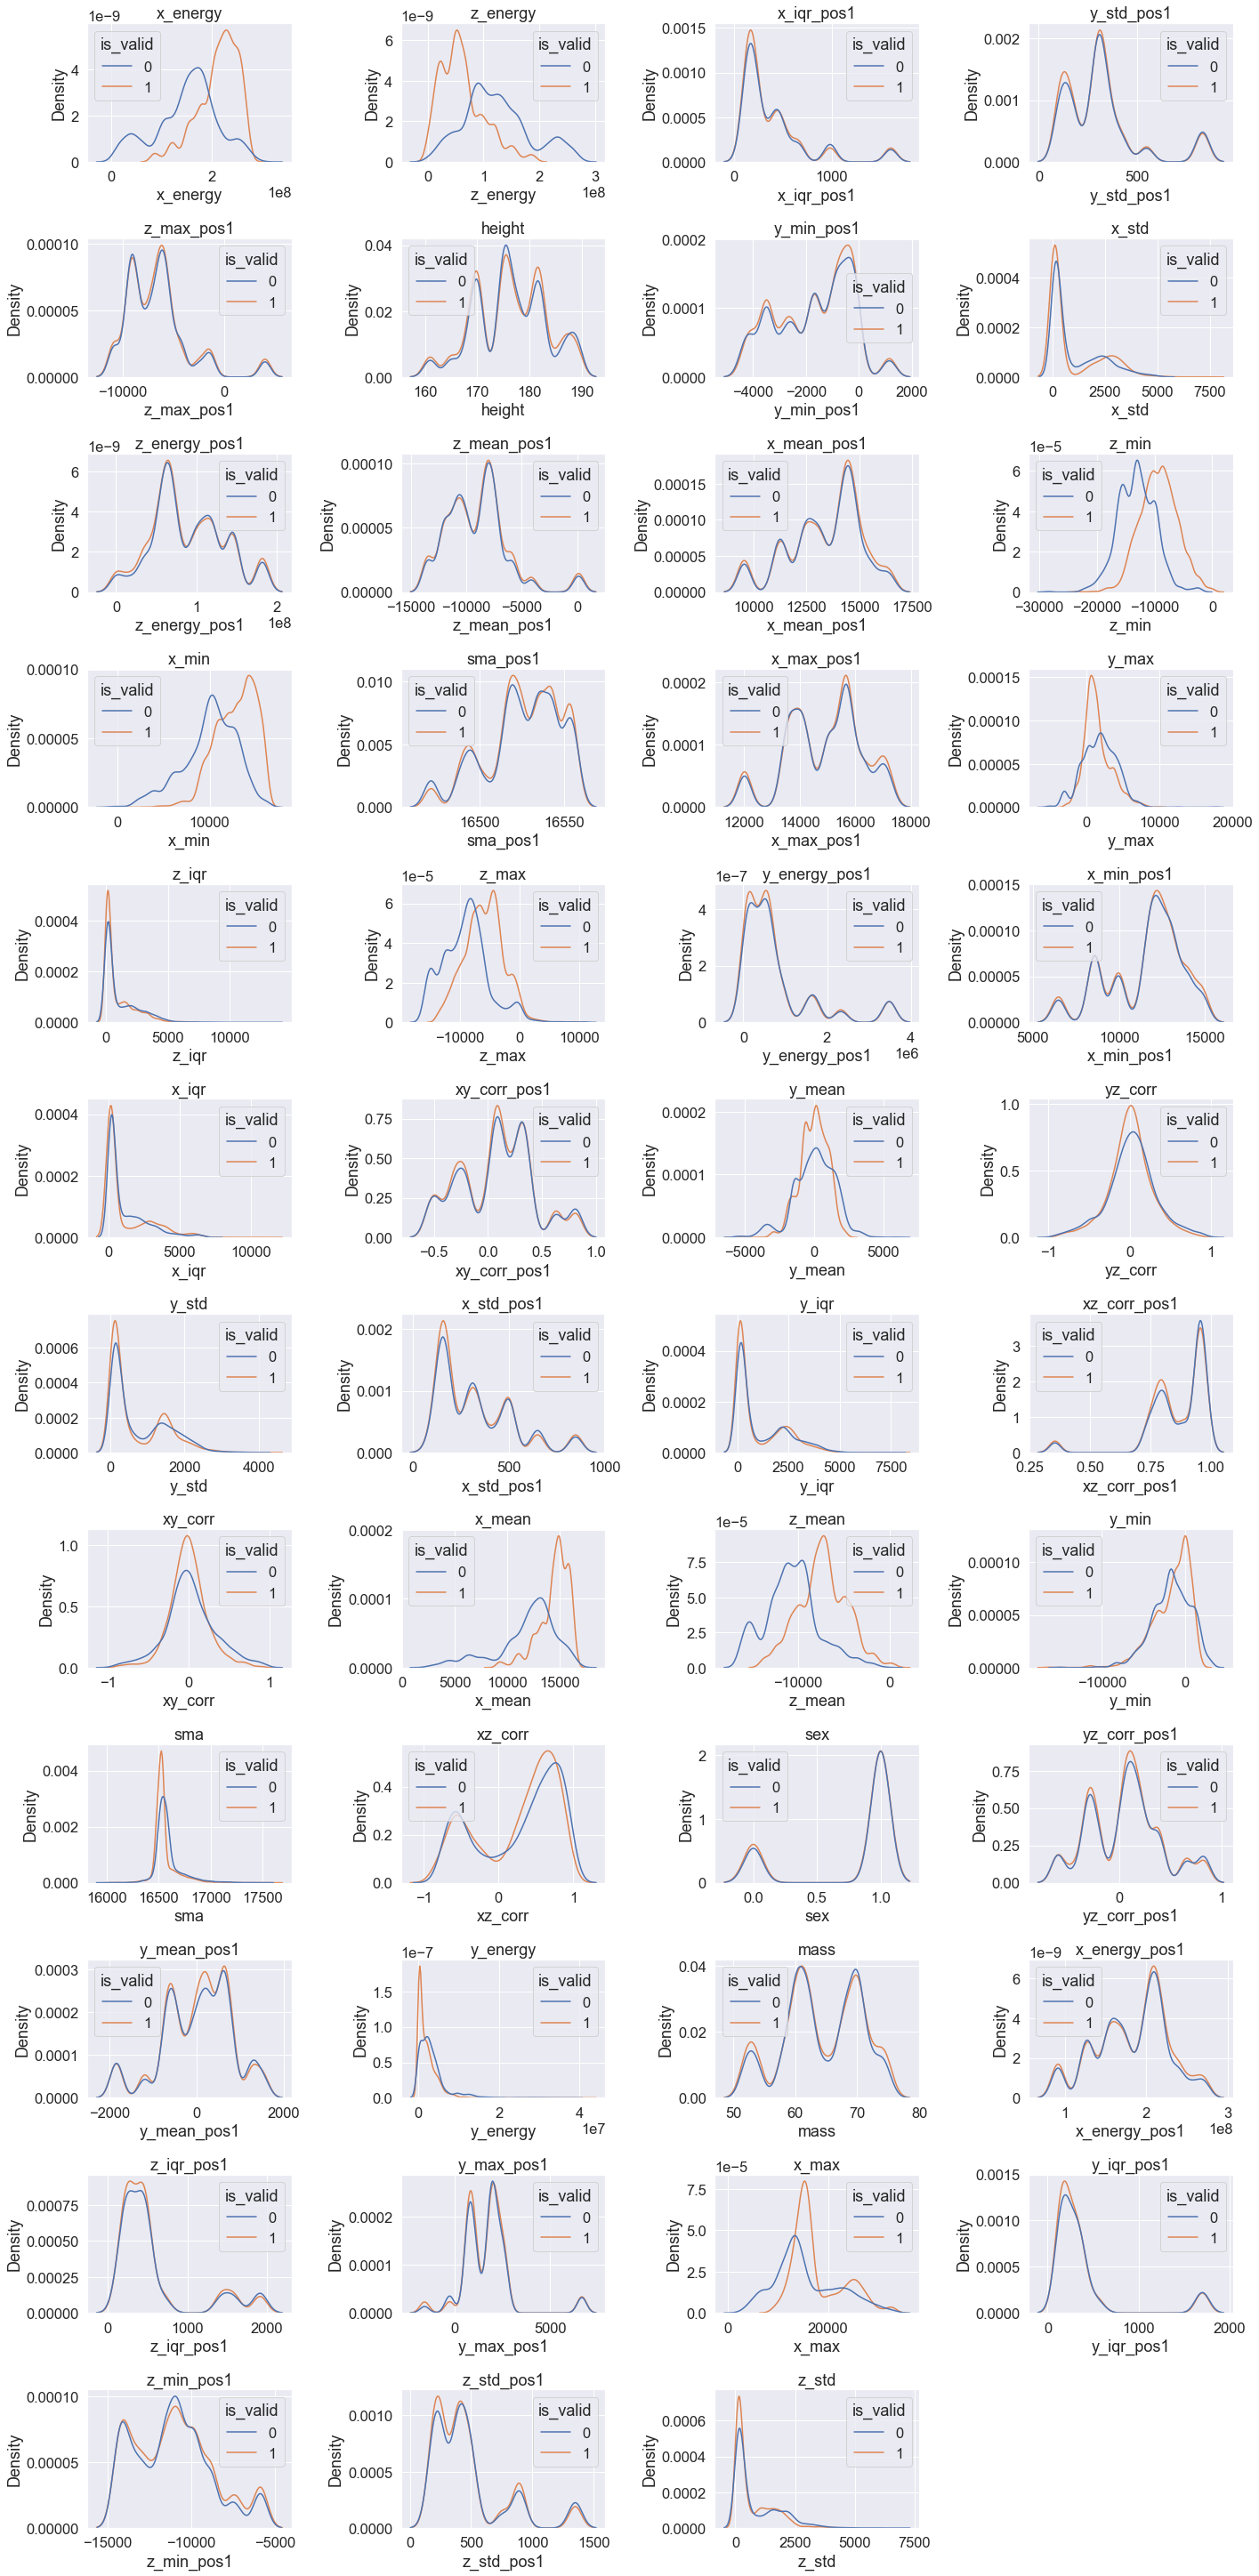

In [170]:
plt.figure(figsize=(20, 50))
for i, metric in enumerate(sorted_metrics):
    plt.subplot(15, 4, i+1)
    sns.kdeplot(x=metric, hue='is_valid', data=data)
    plt.title(metric)
plt.tight_layout()
plt.show()

Оценка важности признака путем его удаления.

In [10]:
init_acc = 0.836
diff_acc_dict = dict()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=1234
)

In [19]:
for metric in tqdm(sorted_metrics):
    
    X_test_cut = X_test.drop(metric, axis=1).to_numpy()
    X_train_cut = X_train.drop(metric, axis=1).to_numpy()
    
    scaler = StandardScaler().fit(X_train_cut)

    X_train_cut = scaler.transform(X_train_cut)
    
    svc = SVC(kernel='linear', C=C).fit(X_train_cut, y_train)
    
    y_pred = svc.predict(scaler.transform(X_test_cut))
    accuracy = accuracy_score(y_test, y_pred)
    
    diff_acc_dict[metric] = init_acc - accuracy
    print(f"{metric}: {diff_acc_dict[metric]:.4f}")

  2%|▏         | 1/47 [00:02<02:07,  2.77s/it]

x_energy: 0.0051


  4%|▍         | 2/47 [00:05<02:09,  2.87s/it]

z_energy: 0.0012


  6%|▋         | 3/47 [00:08<02:14,  3.05s/it]

x_iqr_pos1: -0.0002


  9%|▊         | 4/47 [00:12<02:11,  3.05s/it]

y_std_pos1: -0.0017


 11%|█         | 5/47 [00:14<02:06,  3.01s/it]

z_max_pos1: -0.0002


 13%|█▎        | 6/47 [00:17<02:00,  2.95s/it]

height: 0.0012


 15%|█▍        | 7/47 [00:20<01:55,  2.88s/it]

y_min_pos1: 0.0001


 17%|█▋        | 8/47 [00:23<01:51,  2.85s/it]

x_std: -0.0013


 19%|█▉        | 9/47 [00:26<01:47,  2.83s/it]

z_energy_pos1: -0.0002


 21%|██▏       | 10/47 [00:28<01:42,  2.78s/it]

z_mean_pos1: -0.0006


 23%|██▎       | 11/47 [00:31<01:40,  2.80s/it]

x_mean_pos1: -0.0002


 26%|██▌       | 12/47 [00:34<01:36,  2.76s/it]

z_min: 0.0001


 28%|██▊       | 13/47 [00:37<01:33,  2.75s/it]

x_min: -0.0017


 30%|██▉       | 14/47 [00:39<01:30,  2.75s/it]

sma_pos1: 0.0012


 32%|███▏      | 15/47 [00:42<01:27,  2.72s/it]

x_max_pos1: -0.0006


 34%|███▍      | 16/47 [00:45<01:23,  2.69s/it]

y_max: -0.0027


 36%|███▌      | 17/47 [00:47<01:21,  2.73s/it]

z_iqr: -0.0002


 38%|███▊      | 18/47 [00:50<01:18,  2.71s/it]

z_max: -0.0002


 40%|████      | 19/47 [00:53<01:16,  2.72s/it]

y_energy_pos1: -0.0009


 43%|████▎     | 20/47 [00:55<01:13,  2.72s/it]

x_min_pos1: 0.0001


 45%|████▍     | 21/47 [00:58<01:10,  2.72s/it]

x_iqr: -0.0006


 47%|████▋     | 22/47 [01:01<01:08,  2.73s/it]

xy_corr_pos1: 0.0001


 49%|████▉     | 23/47 [01:04<01:04,  2.69s/it]

y_mean: -0.0017


 51%|█████     | 24/47 [01:06<01:01,  2.67s/it]

yz_corr: -0.0013


 53%|█████▎    | 25/47 [01:09<00:58,  2.67s/it]

y_std: -0.0017


 55%|█████▌    | 26/47 [01:12<00:56,  2.68s/it]

x_std_pos1: -0.0006


 57%|█████▋    | 27/47 [01:14<00:54,  2.71s/it]

y_iqr: -0.0009


 60%|█████▉    | 28/47 [01:17<00:51,  2.70s/it]

xz_corr_pos1: 0.0008


 62%|██████▏   | 29/47 [01:20<00:48,  2.69s/it]

xy_corr: -0.0002


 64%|██████▍   | 30/47 [01:22<00:45,  2.69s/it]

x_mean: 0.0005


 66%|██████▌   | 31/47 [01:25<00:42,  2.68s/it]

z_mean: -0.0006


 68%|██████▊   | 32/47 [01:28<00:40,  2.68s/it]

y_min: 0.0051


 70%|███████   | 33/47 [01:30<00:37,  2.71s/it]

sma: 0.0012


 72%|███████▏  | 34/47 [01:33<00:35,  2.74s/it]

xz_corr: 0.0033


 74%|███████▍  | 35/47 [01:36<00:32,  2.72s/it]

sex: 0.0008


 77%|███████▋  | 36/47 [01:39<00:29,  2.72s/it]

yz_corr_pos1: 0.0001


 79%|███████▊  | 37/47 [01:41<00:27,  2.72s/it]

y_mean_pos1: 0.0019


 81%|████████  | 38/47 [01:44<00:25,  2.81s/it]

y_energy: -0.0009


 83%|████████▎ | 39/47 [01:47<00:22,  2.79s/it]

mass: 0.0001


 85%|████████▌ | 40/47 [01:50<00:19,  2.76s/it]

x_energy_pos1: 0.0001


 87%|████████▋ | 41/47 [01:53<00:16,  2.76s/it]

z_iqr_pos1: -0.0006


 89%|████████▉ | 42/47 [01:55<00:13,  2.76s/it]

y_max_pos1: -0.0013


 91%|█████████▏| 43/47 [01:58<00:11,  2.77s/it]

x_max: -0.0009


 94%|█████████▎| 44/47 [02:01<00:08,  2.82s/it]

y_iqr_pos1: -0.0013


 96%|█████████▌| 45/47 [02:04<00:05,  2.80s/it]

z_min_pos1: 0.0023


 98%|█████████▊| 46/47 [02:07<00:02,  2.79s/it]

z_std_pos1: 0.0001


100%|██████████| 47/47 [02:09<00:00,  2.76s/it]

z_std: 0.0047


In [20]:
sorted_metrics = dict(sorted(diff_acc_dict.items(), key=lambda item: -item[1]))

In [21]:
sorted_metrics

{'x_energy': 0.005094138543516813,
 'y_min': 0.005094138543516813,
 'z_std': 0.00473889875666067,
 'xz_corr': 0.003317939609236209,
 'z_min_pos1': 0.00225222024866778,
 'y_mean_pos1': 0.001896980461811637,
 'z_energy': 0.001186500888099462,
 'height': 0.001186500888099462,
 'sma_pos1': 0.001186500888099462,
 'sma': 0.001186500888099462,
 'xz_corr_pos1': 0.0008312611012433191,
 'sex': 0.0008312611012433191,
 'x_mean': 0.0004760213143871761,
 'y_min_pos1': 0.0001207815275310331,
 'z_min': 0.0001207815275310331,
 'x_min_pos1': 0.0001207815275310331,
 'xy_corr_pos1': 0.0001207815275310331,
 'yz_corr_pos1': 0.0001207815275310331,
 'mass': 0.0001207815275310331,
 'x_energy_pos1': 0.0001207815275310331,
 'z_std_pos1': 0.0001207815275310331,
 'x_iqr_pos1': -0.00023445825932510989,
 'z_max_pos1': -0.00023445825932510989,
 'z_energy_pos1': -0.00023445825932510989,
 'x_mean_pos1': -0.00023445825932510989,
 'z_iqr': -0.00023445825932510989,
 'z_max': -0.00023445825932510989,
 'xy_corr': -0.0002344

In [22]:
sorted_metrics = list(sorted_metrics.keys())

Теперь добавляем по одному признаку и смотрим на каких признаках точность резко возрастает.

In [201]:
for i in tqdm(range(2, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    
    X_test_cut = X_test[metrics].to_numpy()
    X_train_cut = X_train[metrics].to_numpy()
    
    scaler = StandardScaler().fit(X_train_cut)

    X_train_cut = scaler.transform(X_train_cut)
    
    svc = SVC(kernel='linear', C=C).fit(X_train_cut, y_train)
    
    y_pred = svc.predict(scaler.transform(X_test_cut))
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{metrics[-1]}: {accuracy:.3f}")

  2%|▏         | 1/45 [00:01<01:13,  1.67s/it]

y_min: 0.753


  4%|▍         | 2/45 [00:03<01:09,  1.62s/it]

z_std: 0.756


  7%|▋         | 3/45 [00:04<01:00,  1.45s/it]

xz_corr: 0.775


  9%|▉         | 4/45 [00:05<00:59,  1.46s/it]

z_min_pos1: 0.790


 11%|█         | 5/45 [00:07<00:59,  1.48s/it]

y_mean_pos1: 0.791


 13%|█▎        | 6/45 [00:09<00:58,  1.51s/it]

z_energy: 0.798


 16%|█▌        | 7/45 [00:10<01:00,  1.58s/it]

height: 0.796


 18%|█▊        | 8/45 [00:12<01:01,  1.66s/it]

sma_pos1: 0.798


 20%|██        | 9/45 [00:14<01:02,  1.75s/it]

sma: 0.819


 22%|██▏       | 10/45 [00:16<01:01,  1.75s/it]

sex: 0.817


 24%|██▍       | 11/45 [00:18<01:01,  1.81s/it]

z_max: 0.823


 27%|██▋       | 12/45 [00:20<01:01,  1.86s/it]

xz_corr_pos1: 0.824


 29%|██▉       | 13/45 [00:22<00:58,  1.84s/it]

x_mean: 0.822


 31%|███       | 14/45 [00:23<00:57,  1.86s/it]

y_min_pos1: 0.821


 33%|███▎      | 15/45 [00:25<00:57,  1.92s/it]

z_min: 0.823


 36%|███▌      | 16/45 [00:28<00:56,  1.96s/it]

x_min_pos1: 0.826


 38%|███▊      | 17/45 [00:30<00:55,  1.99s/it]

xy_corr_pos1: 0.818


 40%|████      | 18/45 [00:32<00:53,  1.97s/it]

yz_corr_pos1: 0.831


 42%|████▏     | 19/45 [00:33<00:50,  1.95s/it]

mass: 0.832


 44%|████▍     | 20/45 [00:35<00:48,  1.95s/it]

x_energy_pos1: 0.831


 47%|████▋     | 21/45 [00:37<00:46,  1.94s/it]

x_iqr_pos1: 0.832


 49%|████▉     | 22/45 [00:40<00:46,  2.03s/it]

z_max_pos1: 0.833


 51%|█████     | 23/45 [00:41<00:44,  2.00s/it]

z_energy_pos1: 0.832


 53%|█████▎    | 24/45 [00:44<00:42,  2.03s/it]

x_mean_pos1: 0.833


 56%|█████▌    | 25/45 [00:46<00:40,  2.05s/it]

z_iqr: 0.835


 58%|█████▊    | 26/45 [00:48<00:39,  2.08s/it]

x_iqr: 0.834


 60%|██████    | 27/45 [00:50<00:37,  2.10s/it]

xy_corr: 0.835


 62%|██████▏   | 28/45 [00:52<00:37,  2.20s/it]

z_std_pos1: 0.832


 64%|██████▍   | 29/45 [00:55<00:35,  2.22s/it]

z_mean_pos1: 0.840


 67%|██████▋   | 30/45 [00:57<00:33,  2.22s/it]

x_max_pos1: 0.840


 69%|██████▉   | 31/45 [00:59<00:31,  2.25s/it]

y_energy_pos1: 0.837


 71%|███████   | 32/45 [01:02<00:29,  2.30s/it]

x_std_pos1: 0.836


 73%|███████▎  | 33/45 [01:04<00:27,  2.33s/it]

z_mean: 0.835


 76%|███████▌  | 34/45 [01:07<00:26,  2.38s/it]

z_iqr_pos1: 0.831


 78%|███████▊  | 35/45 [01:09<00:23,  2.37s/it]

y_energy: 0.834


 80%|████████  | 36/45 [01:11<00:21,  2.41s/it]

x_max: 0.837


 82%|████████▏ | 37/45 [01:14<00:19,  2.45s/it]

x_std: 0.837


 84%|████████▍ | 38/45 [01:17<00:17,  2.51s/it]

yz_corr: 0.839


 87%|████████▋ | 39/45 [01:19<00:15,  2.51s/it]

y_max_pos1: 0.839


 89%|████████▉ | 40/45 [01:22<00:12,  2.57s/it]

y_iqr_pos1: 0.832


 91%|█████████ | 41/45 [01:24<00:10,  2.56s/it]

y_std_pos1: 0.833


 93%|█████████▎| 42/45 [01:27<00:07,  2.59s/it]

x_min: 0.833


 96%|█████████▌| 43/45 [01:30<00:05,  2.58s/it]

y_std: 0.833


 98%|█████████▊| 44/45 [01:32<00:02,  2.63s/it]

y_iqr: 0.832


100%|██████████| 45/45 [01:35<00:00,  2.12s/it]

y_mean: 0.839


Корреляция таргета от всех признаков.

In [288]:
abs(data.corr()['is_valid']).sort_values(ascending=False)

is_valid         1.000000
z_energy         0.522120
x_energy         0.512773
z_mean           0.511550
z_min            0.508690
x_mean           0.497058
x_min            0.479958
z_max            0.397898
y_energy         0.208794
x_max            0.189474
sma              0.144284
z_std            0.093173
z_iqr            0.078794
y_max            0.065925
y_std            0.052830
y_iqr            0.048300
xy_corr          0.047732
xz_corr_pos1     0.033970
yz_corr          0.031784
y_mean           0.027899
z_min_pos1       0.026340
y_iqr_pos1       0.023883
y_std_pos1       0.023129
z_mean_pos1      0.023054
z_std_pos1       0.022646
sex              0.021797
x_std_pos1       0.021617
x_energy_pos1    0.019791
z_energy_pos1    0.019038
xz_corr          0.018091
x_std            0.017883
x_mean_pos1      0.017361
y_energy_pos1    0.017324
xy_corr_pos1     0.016630
sma_pos1         0.015922
z_iqr_pos1       0.014908
yz_corr_pos1     0.014144
y_min            0.013443
x_max_pos1  

Смотрим на таблицу корреляции, чтобы избавиться от линейно зависимых признаков.

In [306]:
corr_df = data.corr()
corr_df

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
x_mean,1.000000,0.230381,0.622822,0.755118,0.982512,0.208821,-0.082642,0.207898,0.115484,-0.219728,...,-0.122016,-0.170220,-0.046858,-0.038558,-0.146659,-0.017807,-0.029322,-0.009268,0.497058,-0.136031
x_std,0.230381,1.000000,0.873125,-0.422063,0.299958,0.948720,-0.049799,0.865189,0.679189,-0.724438,...,-0.036988,-0.060389,-0.022452,0.034233,-0.101202,0.007064,-0.079091,-0.017998,-0.017883,-0.075061
x_max,0.622822,0.873125,1.000000,0.024151,0.664802,0.781344,-0.045824,0.776227,0.605493,-0.643943,...,-0.062633,-0.120062,-0.017709,0.010370,-0.136754,0.006875,-0.061090,-0.008696,0.189474,-0.110812
x_min,0.755118,-0.422063,0.024151,1.000000,0.696207,-0.408828,-0.041758,-0.373635,-0.348895,0.291902,...,-0.089227,-0.101791,-0.028243,-0.064474,-0.076725,-0.029354,0.024708,-0.000776,0.479958,-0.080761
x_energy,0.982512,0.299958,0.664802,0.696207,1.000000,0.278693,-0.097178,0.252757,0.147141,-0.273773,...,-0.145332,-0.183717,-0.047133,-0.037042,-0.169501,-0.024887,-0.037670,0.006642,0.512773,-0.141184
x_iqr,0.208821,0.948720,0.781344,-0.408828,0.278693,1.000000,-0.067444,0.802852,0.618797,-0.690872,...,-0.047303,-0.051303,-0.032149,0.044383,-0.102046,0.006522,-0.069823,-0.017157,0.004076,-0.091469
y_mean,-0.082642,-0.049799,-0.045824,-0.041758,-0.097178,-0.067444,1.000000,-0.057006,0.563762,0.597606,...,0.072247,-0.192231,0.051341,-0.092078,0.117170,-0.020557,0.187222,0.179316,-0.027899,0.075044
y_std,0.207898,0.865189,0.776227,-0.373635,0.252757,0.802852,-0.057006,1.000000,0.743275,-0.767851,...,0.045024,0.086116,0.056712,0.013583,-0.029169,-0.009753,-0.080273,-0.022761,-0.052830,0.001170
y_max,0.115484,0.679189,0.605493,-0.348895,0.147141,0.618797,0.563762,0.743275,1.000000,-0.256796,...,0.052020,-0.085553,0.050358,-0.022551,0.031197,0.000546,0.045223,0.095011,-0.065925,0.017275
y_min,-0.219728,-0.724438,-0.643943,0.291902,-0.273773,-0.690872,0.597606,-0.767851,-0.256796,1.000000,...,0.027427,-0.116721,0.011912,-0.071096,0.123813,-0.011445,0.174476,0.111720,0.013443,0.054418


На самом деле здесь очень много зависимых признаков. Поэтому выделяем кластеры зависимых признаков и выбираем один признак из этого кластера.

In [307]:
corr_df = abs(corr_df)

In [308]:
lin_ind_df = corr_df > 0.80

In [309]:
lin_ind_df.values[[np.arange(lin_ind_df.shape[0])]*2] = False

/home/gizard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [310]:
lin_ind_df

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
x_mean,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
x_std,False,False,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
x_max,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
x_min,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
x_energy,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
x_iqr,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
y_mean,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
y_std,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
y_max,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
y_min,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Здесь алгоритм поиска компонент связности.

Добавление новых признаков.

In [23]:
metrics = sorted_metrics[:10]
metrics.remove('height')
metrics.extend(['z_mean'])
metrics.append('is_valid')

In [24]:
research_data = data[metrics]
research_data.head()

,x_energy,y_min,z_std,xz_corr,z_min_pos1,y_mean_pos1,z_energy,sma_pos1,sma,z_mean,is_valid
0,1.244884e+08,920.0,133.564763,0.770160,-7132.0,-1865.611722,1.477947e+08,16491.939761,16541.684983,-12156.36,0
1,1.244924e+08,920.0,135.868766,0.781109,-7132.0,-1865.611722,1.478119e+08,16491.939761,16540.861298,-12157.04,0
2,1.244376e+08,164.0,142.634242,0.758313,-7132.0,-1865.611722,1.478196e+08,16491.939761,16536.815163,-12157.28,0
3,1.211331e+08,-1032.0,361.460157,0.935952,-7132.0,-1865.611722,1.511646e+08,16491.939761,16530.673643,-12289.64,0
4,1.186066e+08,-1032.0,355.243302,0.910812,-7132.0,-1865.611722,1.538324e+08,16491.939761,16525.683692,-12397.88,0


In [25]:
y = research_data['is_valid']
X = research_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.816
SVC accuracy: 0.822


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

Исследуем разделимости классов по графикам

In [337]:
scaled_df = StandardScaler().fit_transform(data.drop('is_valid', axis=1))
scaled_df = data[metrics].copy()
scaled_df.loc[:,'is_valid'] = data['is_valid'].copy()

scaled_df = pd.DataFrame(scaled_df, index=scaled_df.index, columns=scaled_df.columns)

<Figure size 2160x2160 with 0 Axes>

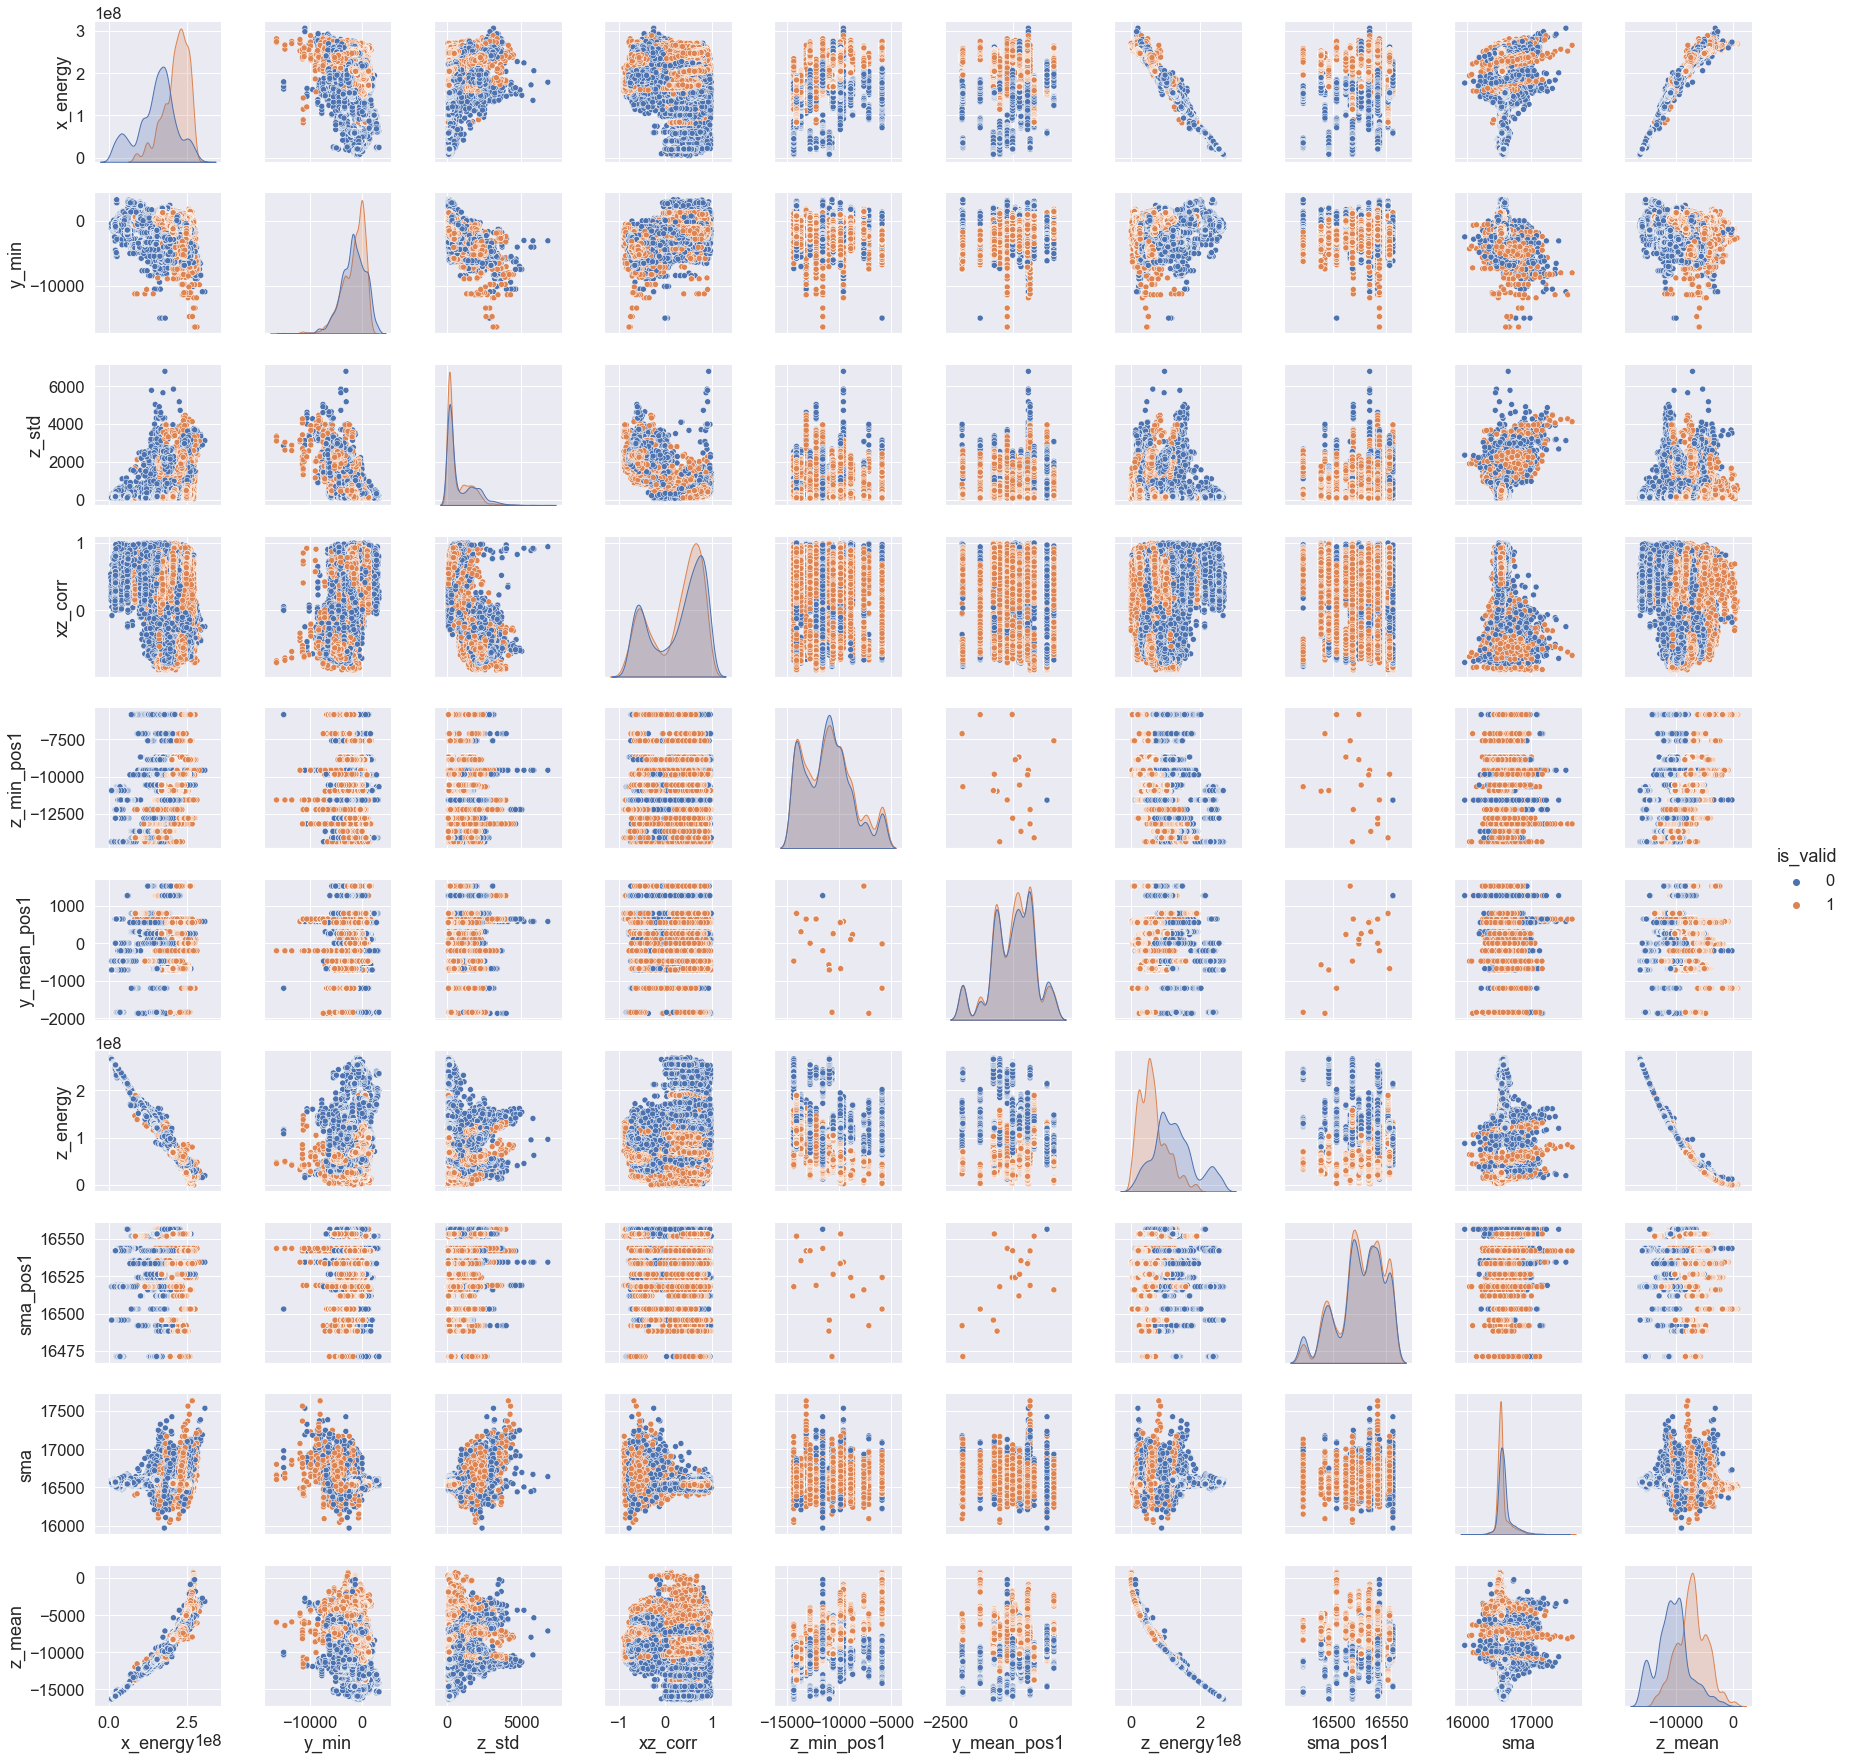

In [338]:
plt.figure(figsize=(30, 30))
sns.pairplot(scaled_df, hue='is_valid')

Добавим sma^2, log(x_energy)

In [105]:
new_data = data.copy()

In [106]:
new_data['sma^2'] = data['sma']**2
new_data['sma^3'] = data['sma']**3
new_data['log(sma)'] = np.log(data['sma'])
new_data['sqrt(sma)'] = np.sqrt(data['sma'])

In [107]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.824
SVC accuracy: 0.835


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [108]:
new_data['x_energy^2'] = data['x_energy']**2
new_data['x_energy^3'] = data['x_energy']**3
new_data['log(x_energy)'] = np.log(data['x_energy'])
new_data['sqrt(x_energy)'] = np.sqrt(data['x_energy'])

In [109]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.826
SVC accuracy: 0.841


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [110]:
new_data['y_mean^2'] = data['y_mean']**2
new_data['y_mean^3'] = data['y_mean']**3
new_data['log(y_mean)'] = np.log(abs(data['y_mean']))
new_data['sqrt(y_mean)'] = np.sqrt(abs(data['y_mean']))

In [111]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.835
SVC accuracy: 0.844


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [112]:
new_data['y_min^2'] = data['y_min']**2
new_data['y_min^3'] = data['y_min']**3
new_data['log(y_min)'] = np.log(abs(data['y_min']))
new_data['sqrt(y_min)'] = np.sqrt(abs(data['y_min']))

In [113]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.843
SVC accuracy: 0.850


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [114]:
new_data['z_mean^2'] = data['z_mean']**2
new_data['z_mean^3'] = data['z_mean']**3
new_data['log(z_mean)'] = np.log(abs(data['z_mean']))
new_data['sqrt(z_mean)'] = np.sqrt(abs(data['z_mean']))

In [115]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.846
SVC accuracy: 0.850


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [116]:
new_data['z_energy^2'] = data['z_energy']**2
new_data['z_energy^3'] = data['z_energy']**3
new_data['log(z_energy)'] = np.log(data['z_energy'])
new_data['sqrt(z_energy)'] = np.sqrt(data['z_energy'])

In [117]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.848
SVC accuracy: 0.855


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [118]:
new_data['x_mean_pos1^2'] = data['x_mean_pos1']**2
new_data['x_mean_pos1^3'] = data['x_mean_pos1']**3
new_data['log(x_mean_pos1)'] = np.log(abs(data['x_mean_pos1']))
new_data['sqrt(x_mean_pos1)'] = np.sqrt(abs(data['x_mean_pos1']))

In [119]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.850
SVC accuracy: 0.855


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))

In [120]:
new_data['y_energy^2'] = data['y_energy']**2
new_data['y_energy^3'] = data['y_energy']**3
new_data['log(y_energy)'] = np.log(abs(data['y_energy']))
new_data['sqrt(y_energy)'] = np.sqrt(abs(data['y_energy']))

In [121]:
y = new_data['is_valid']
X = new_data.drop('is_valid', axis=1)

evaluate_metrics(X, y)

LogReg accuracy: 0.855
SVC accuracy: 0.858


(LogisticRegression(C=2, max_iter=10000, multi_class='multinomial',
                    random_state=42),
 SVC(C=2, kernel='linear'))